In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed

set_seed(455)
np.random.seed(455)

In [2]:
dataset = pd.read_csv("Mastercard_stock_history.csv", index_col="Date", parse_dates=["Date"]
).drop(["Dividends", "Stock Splits"], axis=1)
print(dataset.head())

                Open      High       Low     Close     Volume
Date                                                         
2006-05-25  3.748967  4.283869  3.739664  4.279217  395343000
2006-05-26  4.307126  4.348058  4.103398  4.179680  103044000
2006-05-30  4.183400  4.184330  3.986184  4.093164   49898000
2006-05-31  4.125723  4.219679  4.125723  4.180608   30002000
2006-06-01  4.179678  4.474572  4.176887  4.419686   62344000


In [3]:
print(dataset.describe())

              Open         High          Low        Close        Volume
count  3872.000000  3872.000000  3872.000000  3872.000000  3.872000e+03
mean    104.896814   105.956054   103.769349   104.882714  1.232250e+07
std     106.245511   107.303589   105.050064   106.168693  1.759665e+07
min       3.748967     4.102467     3.739664     4.083861  6.411000e+05
25%      22.347203    22.637997    22.034458    22.300391  3.529475e+06
50%      70.810079    71.375896    70.224002    70.856083  5.891750e+06
75%     147.688448   148.645373   146.822013   147.688438  1.319775e+07
max     392.653890   400.521479   389.747812   394.685730  3.953430e+08


In [4]:
dataset.isna().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

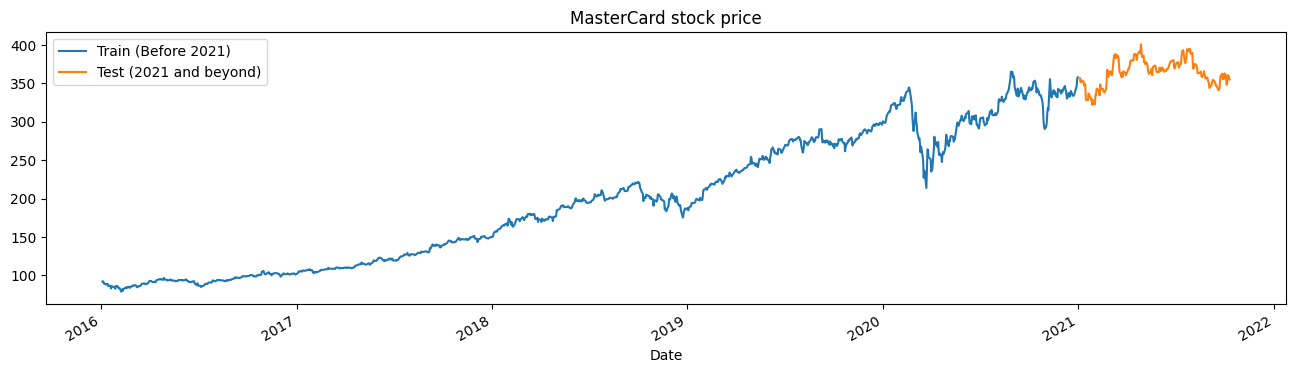

In [5]:
tstart = 2016
tend = 2020

def train_test_plot(dataset, tstart, tend):
    dataset.loc[f"{tstart}":f"{tend}", "High"].plot(figsize=(16, 4), legend=True)
    dataset.loc[f"{tend+1}":, "High"].plot(figsize=(16, 4), legend=True)
    plt.legend([f"Train (Before {tend+1})", f"Test ({tend+1} and beyond)"])
    plt.title("MasterCard stock price")
    plt.show()

train_test_plot(dataset,tstart,tend)

In [6]:
def train_test_split(dataset, tstart, tend):
    train = dataset.loc[f"{tstart}":f"{tend}", "High"].values
    test = dataset.loc[f"{tend+1}":, "High"].values
    return train, test
training_set, test_set = train_test_split(dataset, tstart, tend)

In [7]:
sc = MinMaxScaler(feature_range=(0, 1))
training_set = training_set.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)

In [8]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


n_steps = 60
features = 1
# split into samples
X_train, y_train = split_sequence(training_set_scaled, n_steps)


In [9]:
# Reshaping X_train for model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],features)


In [10]:
# The LSTM architecture
model_lstm = Sequential()
model_lstm.add(LSTM(units=125, activation="tanh", input_shape=(n_steps, features)))
model_lstm.add(Dense(units=1))
# Compiling the model
model_lstm.compile(optimizer="RMSprop", loss="mse")

model_lstm.summary()

C:\Users\sumit\OneDrive\Desktop\IBM-INTERNSHIP-WORK\inb\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 125)                 │          63,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             126 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 63,626 (248.54 KB)

 Trainable params: 63,626 (248.54 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0370
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0028
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0014
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0018
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0011
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0011
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 8.8818e-04
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 7.7778e-04
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 7.1319e-04
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 8.8042e-04
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 8.0295e-04
Epoch 12/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 7.5940e-04
Epoch 13/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 7.2222e-04
Epoch 14/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 6.8887e-04
Epoch 15/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 

In [12]:
dataset_total = dataset.loc[:,"High"]
inputs = dataset_total[len(dataset_total) - len(test_set) - n_steps :].values
inputs = inputs.reshape(-1, 1)
#scaling
inputs = sc.transform(inputs)

# Split into samples
X_test, y_test = split_sequence(inputs, n_steps)
# reshape
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)
#prediction
predicted_stock_price = model_lstm.predict(X_test)
#inverse transform the values
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


In [13]:
def plot_predictions(test, predicted):
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("MasterCard Stock Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("MasterCard Stock Price")
    plt.legend()
    plt.show()


def return_rmse(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {:.2f}.".format(rmse))


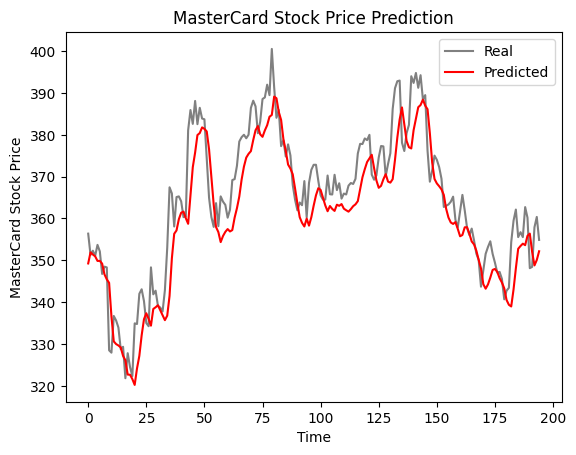

In [14]:
plot_predictions(test_set,predicted_stock_price)

In [15]:
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 7.66.


In [16]:
model_gru = Sequential()
model_gru.add(GRU(units=125, activation="tanh", input_shape=(n_steps, features)))
model_gru.add(Dense(units=1))
# Compiling the RNN
model_gru.compile(optimizer="RMSprop", loss="mse")

model_gru.summary()

C:\Users\sumit\OneDrive\Desktop\IBM-INTERNSHIP-WORK\inb\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 125)                 │          48,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             126 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 48,126 (187.99 KB)

 Trainable params: 48,126 (187.99 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
model_gru.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0423
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0022
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0013
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0011
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0010
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 8.5725e-04
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 8.7017e-04
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 6.7639e-04
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 7.9244e-04
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 7.3003e-04
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 6.9475e-04
Epoch 12/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 6.5331e-04
Epoch 13/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 6.6679e-04
Epoch 14/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 5.9330e-04
Epoch 15/50
38/38 ━━━━━━━━━━━━━━━━━

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


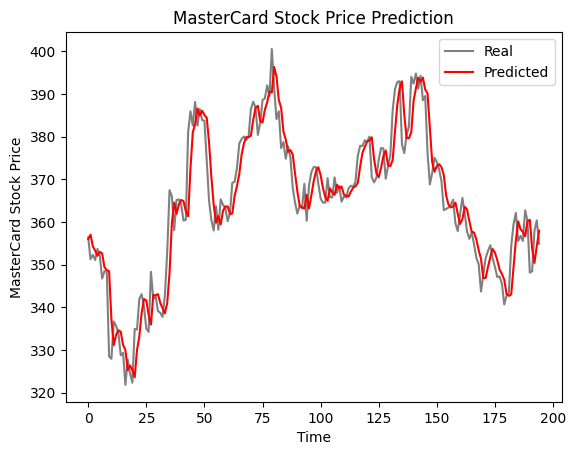

In [18]:
GRU_predicted_stock_price = model_gru.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)
plot_predictions(test_set, GRU_predicted_stock_price)

In [19]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Example: List of text samples
texts = ["I love this product", "This is terrible"]

# Initialize tokenizer
tokenizer = Tokenizer(num_words=5000)  # Consider using a max vocabulary size
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index


In [20]:
# Pad sequences to ensure uniform input length
maxlen = 100  # Set a maximum length for sequences
padded_sequences = pad_sequences(sequences, maxlen=maxlen)
from sklearn.model_selection import train_test_split

# Example labels: 1 = positive, 0 = negative
labels = [1, 0]

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2)


In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# Create LSTM model
model = Sequential()

# Embedding layer: convert integer sequences into dense word vectors
model.add(Embedding(input_dim=5000, output_dim=128, input_length=maxlen))

# LSTM layer
model.add(LSTM(units=128))

# Output layer (sigmoid for binary classification)
model.add(Dense(1, activation='sigmoid'))

# Compile the model (using binary_crossentropy for binary classification)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


C:\Users\sumit\OneDrive\Desktop\IBM-INTERNSHIP-WORK\inb\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [23]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32,callbacks=[early_stopping])
# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


ValueError: Unrecognized data type: x=[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 5 6]] (of type <class 'numpy.ndarray'>)

In [ ]:
from tensorflow.keras.layers import Dropout

# Modified model with Dropout
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=maxlen))
model.add(LSTM(units=128, return_sequences=True))
model.add(Dropout(0.5))  # Dropout to prevent overfitting
model.add(LSTM(units=64))
model.add(Dense(1, activation='sigmoid'))

# Compile and train
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=32,callbacks=[early_stopping])
# Save the model
model.save('lstm_text_classification_model.h5')

# Load the model
from keras.models import load_model
model = load_model('lstm_text_classification_model.h5')
# Example new text
new_texts = ["This is an amazing product!"]
new_sequences = tokenizer.texts_to_sequences(new_texts)
new_padded_sequences = pad_sequences(new_sequences, maxlen=maxlen)

# Predict the class (positive/negative)
prediction = model.predict(new_padded_sequences)
print(f"Prediction: {prediction[0]}")
